In [1]:
from src import create_generator

K = 5
# generator = create_generator("real", n_doc=800, lam=0.8, path="../data")
generator = create_generator("synthetic", n_doc=1000, n_query=10000, lam=0.5)

rel_mat, _ = generator.generate_rel_mat()
expo = generator.exam_func(K=K)

# min-max normalization
rel_mat = (rel_mat - rel_mat.min()) / (rel_mat.max() - rel_mat.min())

In [ ]:
import pandas as pd


def scaling(x: pd.DataFrame) -> pd.DataFrame:
    return (x - x.min()) / (x.max() - x.min())

100%|██████████| 10/10 [01:01<00:00,  6.13s/it]


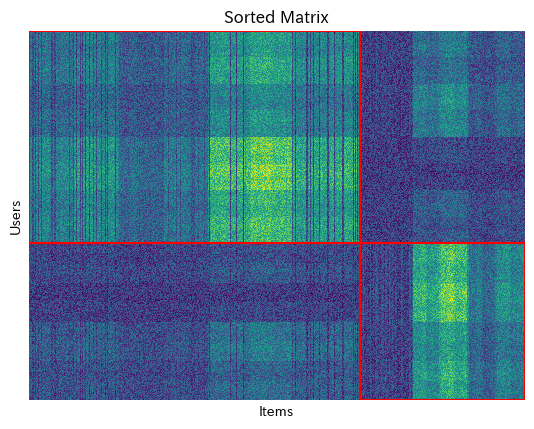

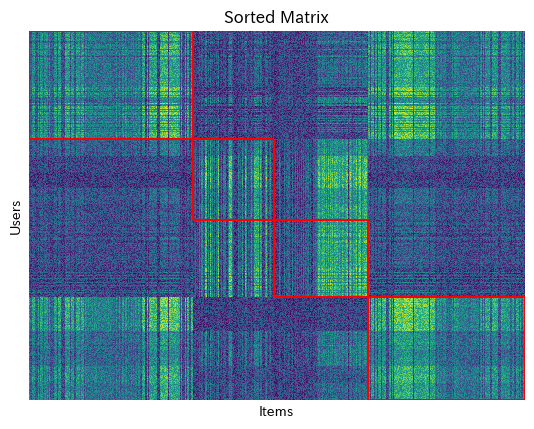

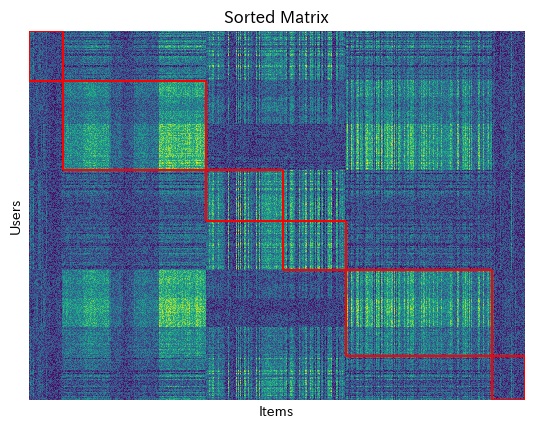

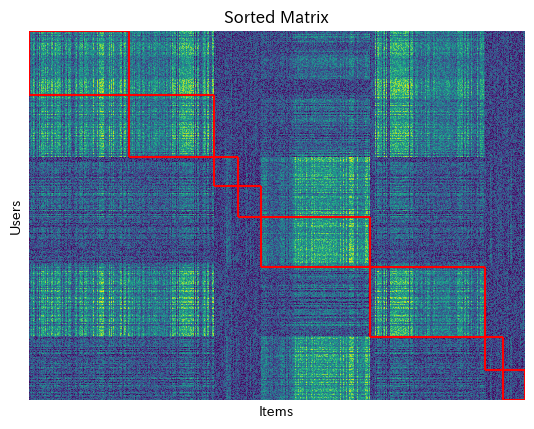

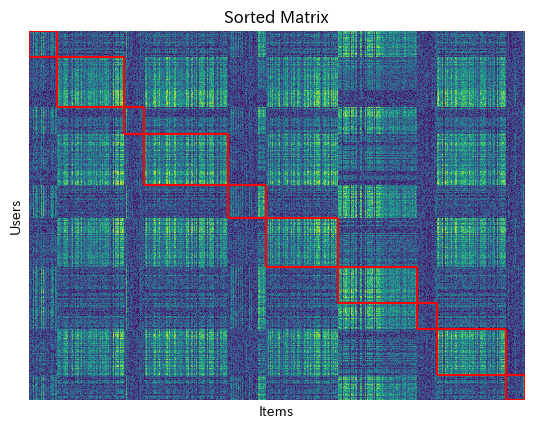

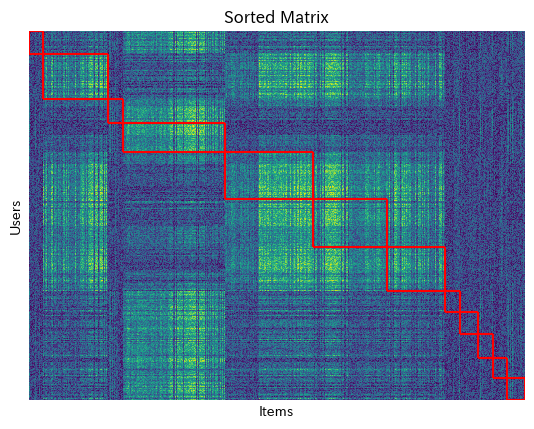

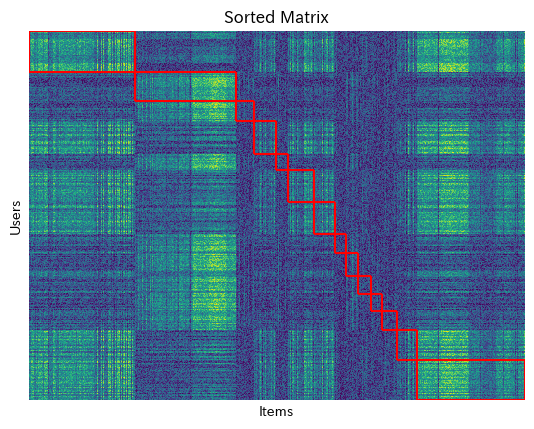

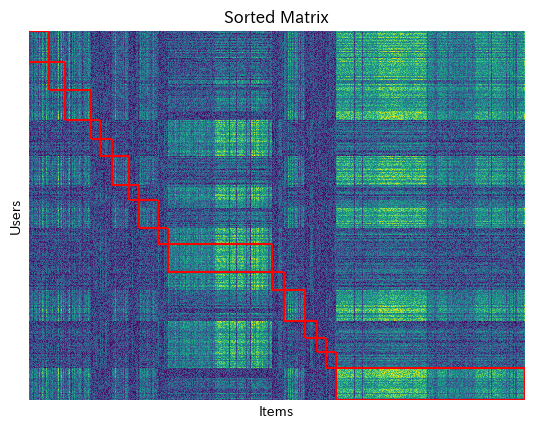

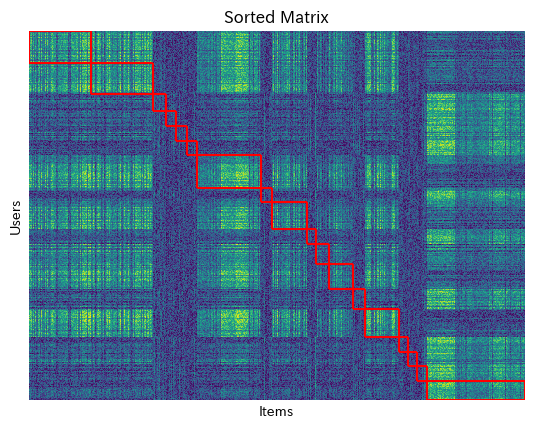

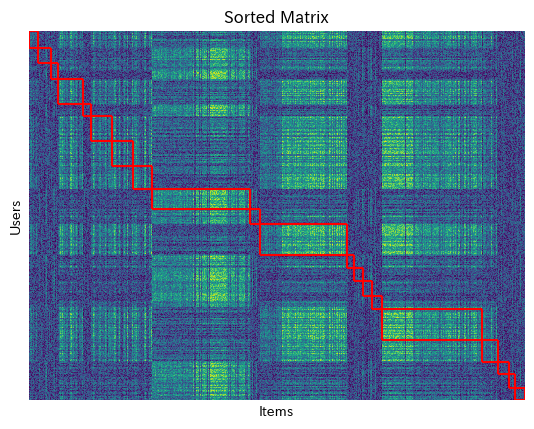

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import SpectralCoclustering
from tqdm import tqdm

from src import create_optimizer, evaluate_pi

A = rel_mat
optimizer = create_optimizer(
    "ot_nsw", alpha=0.0, eps=1.0, max_iter=100, lr=0.5, device="cuda", use_amp=False, tol=0.01
)
results = []
# スペクトラルクラスタリングを適用
for k in tqdm([2, 4, 6, 8, 10, 12, 14, 16, 18, 20]):
    t0 = time.time()
    clustering = SpectralCoclustering(n_clusters=k)
    clustering.fit(A)
    # cluster毎に求解
    pi = np.zeros((A.shape[0], A.shape[1], K))
    for i in range(k):
        row, col = clustering.get_indices(i)
        rel_mat_block = rel_mat[row][:, col]
        pi_block = optimizer.solve(rel_mat_block, expo)
        pi[np.ix_(row, col, np.arange(K))] = pi_block
    t1 = time.time()
    exec_time = t1 - t0
    result_k = evaluate_pi(pi, rel_mat, expo)
    result_k["k"] = k
    result_k["exec_time"] = exec_time

    # 行列の要素数に対するブロックの要素数の割合を計算
    n_rows, n_cols = A.shape
    block_sizes = 0
    for i in range(k):
        row, col = clustering.get_indices(i)
        block_sizes += len(row) * len(col)
    block_ratio = 100 * block_sizes / (n_rows * n_cols)
    result_k["block_ratio"] = block_ratio
    results.append(result_k)

    # ラベルに基づいて行列の順序を入れ替え
    col_indices = np.argsort(clustering.column_labels_)
    row_indices = np.argsort(clustering.row_labels_)
    A_sorted = A[row_indices][:, col_indices]

    # クラスタの境界を計算
    def get_cluster_boundaries(labels):
        boundaries = []
        unique_labels = np.unique(labels)
        for label in unique_labels:
            indices = np.where(labels == label)[0]
            boundaries.append((indices[0], indices[-1] + 1))
        return boundaries

    row_boundaries = get_cluster_boundaries(clustering.row_labels_[row_indices])
    col_boundaries = get_cluster_boundaries(clustering.column_labels_[col_indices])

    # 結果をプロット
    ax: plt.Axes
    fig, ax = plt.subplots()
    cmap = "viridis"
    # sns.heatmap(A, ax=ax[0], cmap=cmap, cbar=False, xticklabels=False, yticklabels=False)
    # ax[0].set_title("Original Matrix")
    sns.heatmap(A_sorted, ax=ax, cmap=cmap, cbar=False, xticklabels=False, yticklabels=False)
    ax.set_title("Sorted Matrix")

    # grid off
    ax.grid(False)
    ax.set_xlabel("Items")
    ax.set_ylabel("Users")

    # 対角ブロックの境界をプロット
    for (row_start, row_end), (col_start, col_end) in zip(row_boundaries, col_boundaries):
        ax.hlines(
            [row_start, row_end], xmin=col_start, xmax=col_end, colors="red", label="cluster"
        )
        ax.vlines(
            [col_start, col_end], ymin=row_start, ymax=row_end, colors="red", label="cluster"
        )
        # print("shape:", row_end - row_start, col_end - col_start)

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional

plt.style.use("ggplot")

METRICS_MAP = {
    "exec_time": "CPU time (s)",
    "exec_time_rate": "実行時間の比率",
    "user_util": "User utility",
    "mean_max_envy": "Mean max envy",
    "pct_item_util_better": "Items better off (%)",
    "pct_item_util_worse": "Items worse off (%)",
}
METRICS = list(METRICS_MAP.keys())
METHOD_MAP = {
    "greedy": "MaxRele",
    "expo_fair": "ExpFair",
    "nsw": "NSW",
    "greedy_nsw": "NSW(Greedy)",
    "ot_nsw": "NSW(Algo1)",
    "pgd_nsw": "NSW (射影勾配法) ",
}
METHOD_TO_COLOR = {
    "MaxRele": "#E24A33",
    "ExpFair": "#FBC15E",
    "ExpFair(Mosek)": "#FBC15E",
    "ExpFair(SCS)": "#FBC15E",
    "NSW(Greedy)": "#777777",
    "NSW (既存) ": "#988ED5",
    "NSW(Mosek)": "#988ED5",
    "NSW(SCS)": "#988ED5",
    "NSW(Algo1)": "#348ABD",
    "NSW(Algo1+GPU)": "#348ABD",
    "NSW (射影勾配法) ": "#8EBA42",
}
METHOD_TO_LINESTYLE = {
    "MaxRele": "-",
    "ExpFair": "-",
    "ExpFair(Mosek)": "-",
    "閲覧公平 (SCS) ": "-",
    "NSW(Greedy)": "-",
    "NSW (既存) ": "-",
    "NSW(Mosek)": "-",
    "NSW (SCS) ": "-",
    "NSW(Algo1)": "--",
    "NSW(Algo1+GPU)": "-",
    "NSW (射影勾配法) ": "-",
}


def plot_fairness_and_user_utils(
    result: pd.DataFrame,
    x: str,
    xlabel: str,
    legend: bool = True,
    errorbar: Optional[tuple[str, float]] = None,
    metrics: list[str] = [
        "user_util",
        "mean_max_envy",
        "pct_item_util_better",
        "pct_item_util_worse",
    ],
):
    ncols = len(metrics)
    figsize_0 = 45 / 4 * ncols
    fig, axes = plt.subplots(ncols=ncols, figsize=(figsize_0, 10), tight_layout=True)
    axes: list[plt.Axes] = np.ravel(axes).tolist()

    unique_method = result["method"].unique().tolist()
    order = [method for method in METHOD_TO_COLOR.keys() if method in unique_method]

    for i, metric in enumerate(metrics):
        ax = axes[i]
        for j, method in enumerate(order):
            color = METHOD_TO_COLOR[method]
            sns.lineplot(
                result.query("method == @method"),
                x=x,
                y=metric,
                ax=ax,
                marker="o",
                markersize=15,
                markers=True,
                linewidth=8,
                linestyle=METHOD_TO_LINESTYLE[method],
                legend=True,
                color=color,
                hue="method",
                palette=[color],
                errorbar=errorbar,
            )

            if metric in [
                "pct_item_util_better",
                "pct_item_util_worse",
            ]:
                ax.set_ylim(-5, 105)
            elif metric == "exec_time":
                ax.set_yscale("log")
                ax.set_ylim(bottom=5e-1, top=5e3)

        ax.set_title(METRICS_MAP[metric], fontsize=52)
        ax.set_ylabel("")
        ax.set_xlabel(xlabel, fontsize=42)
        ax.set_xlim(0, 100)
        ax.tick_params(axis="both", labelsize=35)

        handles, _ = ax.get_legend_handles_labels()
        ax.get_legend().remove()

    if legend:
        fig.legend(
            handles,
            order,
            fontsize=50,
            bbox_to_anchor=(0.5, 1.15),
            ncol=len(order),
            loc="upper center",
        )

In [25]:
import pandas as pd

result_df = pd.DataFrame(results)
result_df["method"] = "NSW(Algo1+GPU)"
result_df["reduction_rate"] = 100 - result_df["block_ratio"]

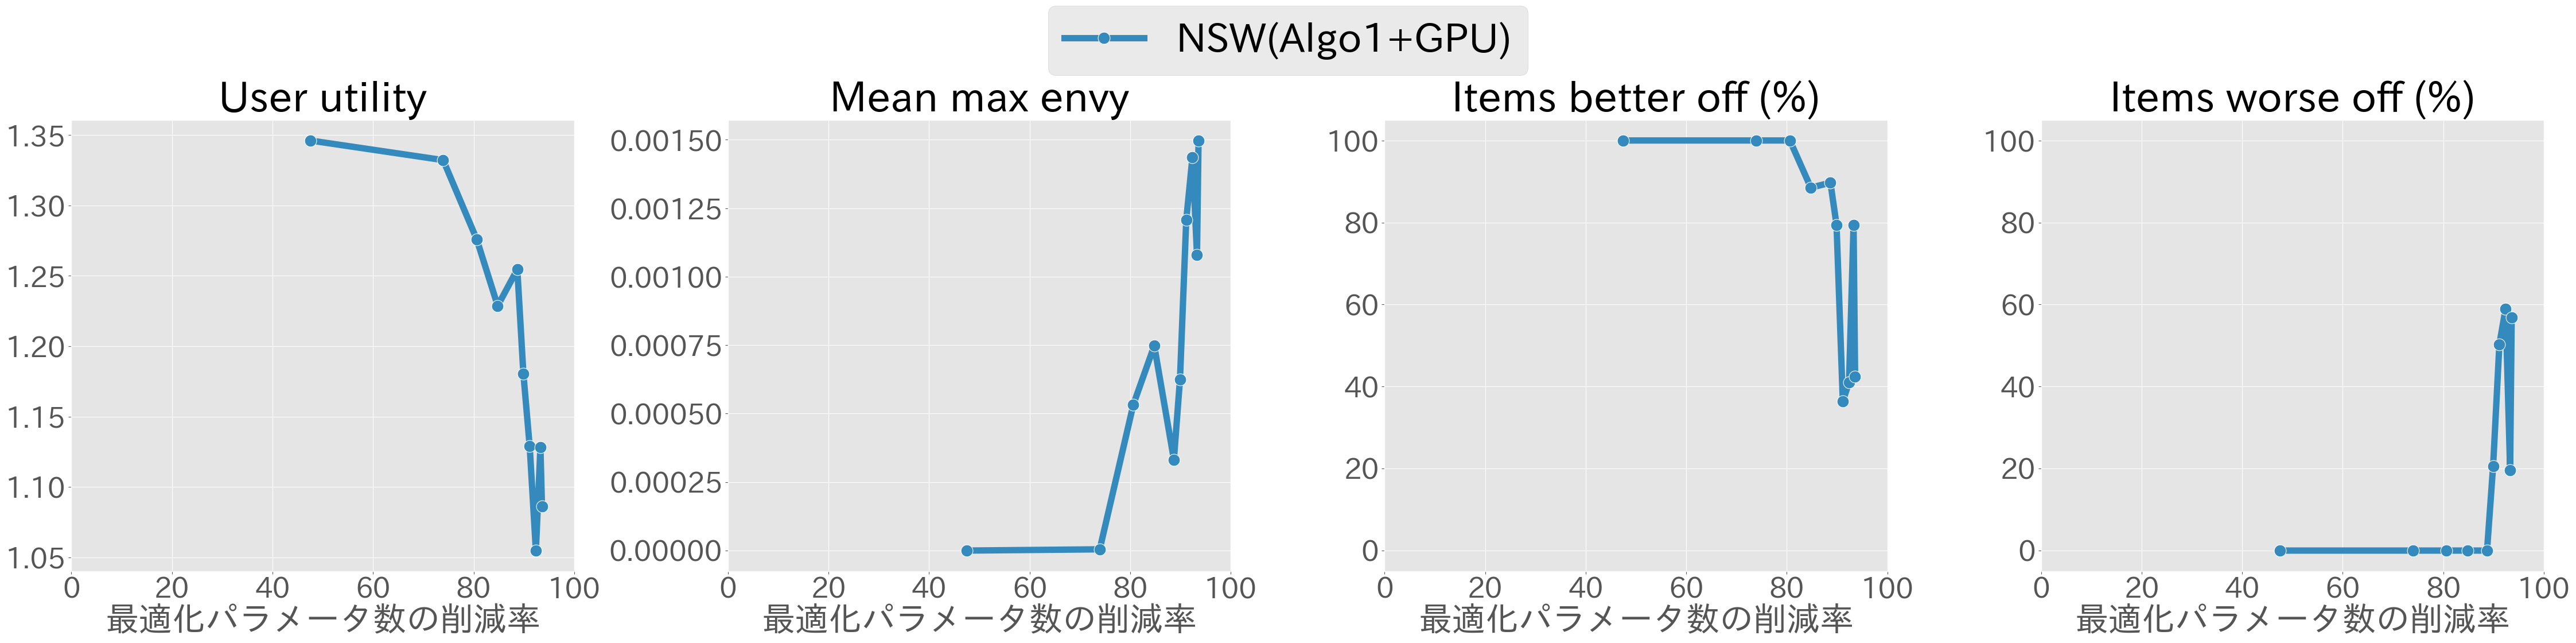

In [26]:
plot_fairness_and_user_utils(result_df, x="reduction_rate", xlabel="最適化パラメータ数の削減率")